# Dermatologist AI Using Tensor Flow and Keras

Summary: This notebook creates a Transfer Learning CNN using a Tensor Flow Backend and Keras. The transfer learning model is the InceptionV3 model. 

The data used is from "The Deep Learning for Cancer Detection" project. The base GIT repository is available git clone https://github.com/udacity/dermatologist-ai.git. 

Some of the coding ideas for how to use InceptionV3 to create a Transfer Learning CNN were from https://deeplearningsandbox.com/how-to-use-transfer-learning-and-fine-tuning-in-keras-and-tensorflow-to-build-an-image-recognition-94b0b02444f2. 

In [93]:
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
import sys
import glob
import argparse
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl
import tensorflow as tf
from keras import __version__
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.models import Model, Sequential
from keras.layers import Dropout, Flatten,Dense, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.preprocessing import image 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from PIL import Image
import seaborn as sns

In [2]:
print('TensorFlow Version:', tf.__version__)
print('Keras Version:', __version__)

TensorFlow Version: 1.2.0
Keras Version: 2.1.1


Step 1: Data Preparation
Use OS library to create a list of all images in train, test, and validate
Create One-Hot Encoding of Labels

In [2]:
top_level_train = os.listdir('data/train')
top_level_test = os.listdir('data/test')
top_level_valid = os.listdir('data/valid')
print(top_level_train, top_level_test, top_level_train)

['nevus', 'seborrheic_keratosis', 'melanoma'] ['nevus', 'seborrheic_keratosis', 'melanoma'] ['nevus', 'seborrheic_keratosis', 'melanoma']


Scroll through all directories of files and generate a list of all images.

In [5]:
def file_parser(high_level, dirs):
    files = []
    for directory in dirs:
        for file in os.listdir(high_level + directory):
            files.append(directory + '/' + file)
    return files
train_files = file_parser('data/train/', top_level_train)
test_files = file_parser('data/test/', top_level_test)
valid_files = file_parser('data/valid/', top_level_valid)
print(len(train_files), len(test_files), len(valid_files))

2000 600 150


Inception Input Needs to be (299, 299, 3). These next steps will resize all images to this for use in the model.

In [17]:
#Image Hyperparameters
IM_WIDTH = 299
IM_HEIGHT = 299

In [8]:
def img_prep(img_path):
    '''
    Function to fetch the image from the image path and return a numpy array of the image.
    The size of the returned image will be defined by IM_WIDTH and IM_HEIGHT (defined above)
    '''
    img = image.load_img(img_path, target_size=(IM_WIDTH, IM_HEIGHT))
    return image.img_to_array(img)

# Get the Data and Labels from the Image Directories

In [15]:
trn_files = []
trn_labels = []
for file in train_files:
    trn_files.append(img_prep('data/train/' + file))
    dir_file = file.split('/')
    trn_labels.append(dir_file[0])

In [10]:
tst_files = []
tst_labels = []
for file in test_files:
    tst_files.append(img_prep('data/test/' + file))
    dir_file = file.split('/')
    tst_labels.append(dir_file[0])

In [11]:
vld_files = []
vld_labels = []
for file in valid_files:
    vld_files.append(img_prep('data/valid/' + file))
    dir_file = file.split('/')
    vld_labels.append(dir_file[0])

In [16]:
#all_files = [trn_files, trn_labels, tst_files, tst_labels, vld_files, vld_labels]

def convert_to_array(lst):
    return np.asarray(lst)

trn_files = convert_to_array(trn_files)
trn_labels = convert_to_array(trn_labels)
tst_files = convert_to_array(tst_files)
tst_labels = convert_to_array(tst_labels)
vld_files = convert_to_array(vld_files)
vld_labels = convert_to_array(vld_labels)

In [23]:
print(type(trn_files))

<class 'numpy.ndarray'>


# Save all Image Data and Labels Using Pickle to Save On Data Prep

Loading data from disk is time consuming the steps below save time the next time you want to run the analysis.

In [24]:
print(len(trn_files), len(trn_labels))
with open('pickled/trn_files.pkl', 'wb') as f:
    pkl.dump(trn_files, f)
with open('pickled/trn_labels.pkl', 'wb') as f:
    pkl.dump(trn_labels, f)

2000 2000


In [25]:
print(len(tst_files), len(tst_labels))
with open('pickled/tst_files.pkl', 'wb') as f:
    pkl.dump(tst_files, f)
with open('pickled/tst_labels.pkl', 'wb') as f:
    pkl.dump(tst_labels, f)

600 600


In [26]:
print(len(vld_files), len(vld_labels))
with open('pickled/vld_files.pkl', 'wb') as f:
    pkl.dump(vld_files, f)
with open('pickled/vld_labels.pkl', 'wb') as f:
    pkl.dump(vld_labels, f)

150 150


# Use This To Skip The Data Prep After Starting the Notebook

In [37]:
#Load Pickled Datasets
with open('pickled/trn_files.pkl', 'rb') as f:
    trn_files = pkl.load(f)
with open('pickled/trn_labels.pkl', 'rb') as f:
    trn_labels = pkl.load(f)
with open('pickled/tst_files.pkl', 'rb') as f:
    tst_files = pkl.load(f)
with open('pickled/tst_labels.pkl', 'rb') as f:
    tst_labels = pkl.load(f)
with open('pickled/vld_files.pkl', 'rb') as f:
    vld_files = pkl.load(f)
with open('pickled/vld_labels.pkl', 'rb') as f:
    vld_labels = pkl.load(f)

Convert Labels to One One Hot Vectors

In [38]:
lb = LabelBinarizer()
lb.fit(trn_labels)
trn_label_vecs = lb.transform(trn_labels)
test_lb = LabelBinarizer()
test_lb.fit(tst_labels)
tst_label_vecs = test_lb.transform(tst_labels)
valid_lb = LabelBinarizer()
valid_lb.fit(vld_labels)
vld_label_vecs = valid_lb.transform(vld_labels)

In [39]:
#Validate One-Hot Vectorization is correct
trn_label_vecs[20]

array([0, 1, 0])

In [40]:
#Shuffle the Data
def randomize_data(files, labels):
    randomize = np.arange(len(files))
    np.random.shuffle(randomize)
    return trn_files[randomize], trn_label_vecs[randomize]
trn_files, trn_label_vecs = randomize_data(trn_files, trn_label_vecs)
tst_files, tst_label_vecs = randomize_data(tst_files, tst_label_vecs)
vld_files, vld_label_vecs = randomize_data(vld_files, vld_label_vecs)

In [6]:
print(len(trn_label_vecs), len(trn_files))
print(type(trn_label_vecs), type(trn_files))

2000 2000
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [100]:
Melanoma = 0
Nevus = 0 
Seborrheic_Keratosis = 0
for label in trn_labels:
    if label == 'melanoma':
        Melanoma += 1
    if label == 'nevus':
        Nevus += 1
    if label == 'seborrheic_keratosis':
        Seborrheic_Keratosis += 1
print(Melanoma, Nevus, Seborrheic_Keratosis)

374 1372 254


# Create Transer Learning Model

The add_new_last_layer function adds two new fully connected layers to the model with relu activation. The function finally adds a softmax layer to handle the prediction of the model. 

In [65]:
def add_new_last_layer(base_model, nb_classes, fc_size, fc_size2, drop):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes
    Returns:
    new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(fc_size, activation='relu')(x) #new FC layer, random init
    x = Dropout(drop)(x)
    x = Dense(fc_size2, activation='relu')(x) #new FC layer, random init
    x = Dropout(drop)(x)
    predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    model = Model(input=base_model.input, output=predictions)
    return model

In [64]:
#Model Hyperparamaters
nb_classes = 3
fc_size = 512
fc_size2 = 256
batch_size = 100
dropout = 0.5

In [66]:
base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
model = add_new_last_layer(base_model, nb_classes, fc_size, fc_size2, dropout)

/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


In [53]:
#Print a summary of the model architecture.
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, None, None, 3 96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, None, None, 3 0           batch_normalization_283[0][0]    
__________________________________________________________________________________________________
conv2d_284

In [54]:
model.save_weights('saved_models/inception_baseline.h5')

In [46]:
i = 0
for layer in model.layers:
    i += 1
print(i)

315


In [67]:
def setup_to_transfer_learn(model):
    """Freeze all pretrained layers and compile the model"""
    for layer in model.layers[:312]:
        layer.trainable = False
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
setup_to_transfer_learn(model)
#Other Optimizers 'adam'. Not much success with SGD(lr=0.0001, momentum=0.9), 'rmsprop'

In [68]:
epochs = 20
batch_size = batch_size

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4, verbose=1, mode='auto')

hist = model.fit(np.array(trn_files), np.array(trn_label_vecs), 
          validation_data=(np.array(vld_files), np.array(vld_label_vecs)),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, early_stopping], verbose=1)

Train on 2000 samples, validate on 150 samples
Epoch 1/20
2000/2000 [==============================] - 45s 22ms/step - loss: 1.0097 - acc: 0.6230 - val_loss: 0.8894 - val_acc: 0.6667
Epoch 2/20
2000/2000 [==============================] - 15s 7ms/step - loss: 0.8402 - acc: 0.6665 - val_loss: 0.8881 - val_acc: 0.6667
Epoch 3/20
2000/2000 [==============================] - 15s 8ms/step - loss: 0.8066 - acc: 0.6745 - val_loss: 0.8592 - val_acc: 0.6667
Epoch 4/20
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7332 - acc: 0.7000 - val_loss: 0.9629 - val_acc: 0.6667
Epoch 5/20
2000/2000 [==============================] - 15s 7ms/step - loss: 0.7221 - acc: 0.7070 - val_loss: 0.7608 - val_acc: 0.6800
Epoch 6/20
2000/2000 [==============================] - 15s 7ms/step - loss: 0.7134 - acc: 0.7065 - val_loss: 0.7414 - val_acc: 0.6800
Epoch 7/20
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6706 - acc: 0.7090 - val_loss: 0.7035 - val_acc: 0.6800
Epoch 8

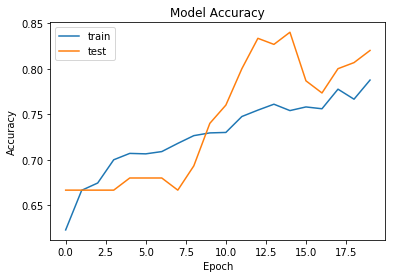

In [69]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

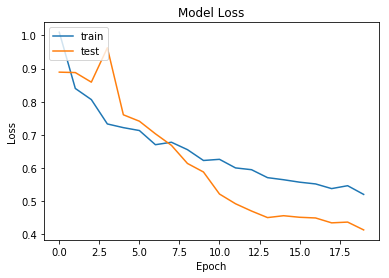

In [70]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predicting with the Model

In [71]:
def predict_image(model, img_matrix): 
    '''
    This function accepts the final model from above and returns a classification of all all three types. 
    ***Args***
    model: CNN Trained above
    img_matrix: image data in a numpy array
    '''
    img = np.expand_dims(img_matrix, axis=0)
    img = preprocess_input(img)
    return model.predict(img)

def convert_prediction(values):
    '''
    This function accepts a numpy array of predicted values and returns a dictionary of predictions of each label.
    ***Args***
    values: Numpy Array of predicted values.
    '''
    labels = ['Melanoma', 'Nevus', 'Seborrheic Keratosis']
    value_hash = {}
    for i in range(len(labels)):
        value_hash[labels[i]] = values[0][i]
    return value_hash

In [72]:
values = predict_image(model, trn_files[0])
predictions = convert_prediction(values)

In [73]:
max(predictions)

'Seborrheic Keratosis'

In [74]:
trn_label_vecs[0]

array([0, 0, 1])